# General Settings and Imports

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
#General imports
import pandas as pd
import numpy as np
import json
from pprint import pprint
from datetime import datetime, timedelta
import os

#Associated Wallets imports
from collections import deque

#Ofac imports
import csv
import requests
import xmltodict
from collections import defaultdict

#Dark Web imports
import dask.dataframe as dd
import yaml

#Flipside imports
#for flipside.xyz (SQL Databse)
#from flipside import Flipside

#Graphsense imports
import graphsense
from graphsense.api import addresses_api, bulk_api, entities_api, general_api, tags_api
from graphsense.model.neighbor_addresses import NeighborAddresses

#Coinbase imports
import hmac, hashlib, time
from requests.auth import AuthBase

#Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

#Mixer/Bridges imports
from collections import namedtuple
from concurrent.futures import ThreadPoolExecutor, as_completed

In [99]:
f = open('config.json')
config = json.load(f)
f.close()

CURRENCY = 'eth'
ADDRESS = '0x75e89d5979E4f6Fba9F97c104c2F0AFB3F1dcB88'

configuration = graphsense.Configuration(
    host = config['graphsense']['host'],
    api_key = {'api_key': config['graphsense']['api_key']})

#with graphsense.ApiClient(configuration) as api_client:
    #api_instance = general_api.GeneralApi(api_client)
    #api_response = api_instance.get_statistics()
    #pprint(api_response)

# Associated Wallets Module

In [100]:
class AssociatedWallets():


    def __init__(self, currency):
        self.currency = currency
                

    #Utility function to get neighbors of address        
    def get_addr_neighbors(self, address, direction):

        if (direction == 'out'):
            degree = 'out_degree'
            address_degree = 'address_out_degree'
        else:
            degree = 'in_degree'
            address_degree = 'address_in_degree'

        with graphsense.ApiClient(configuration) as api_client:
            try:
                api_instance = bulk_api.BulkApi(api_client)
                print(f"get_addr_neighbors of {address.lower()}")
                operation = "list_address_neighbors"
                body = {'address': [address.lower()], 'direction': direction}

                df_address_neighbors = pd.read_csv(api_instance.bulk_csv(self.currency, operation, body=body,
                                                                    num_pages=1, _preload_content=False))
                
                df_address_neighbors = df_address_neighbors \
                    .loc[(df_address_neighbors['_error'] != 'not found') &
                        (df_address_neighbors['_info'] != 'no data')].reset_index(drop=True)
                
                if df_address_neighbors.empty:
                    df_address_neighbors.columns = ['address', 'entity', degree]
                    return df_address_neighbors
                
                print(df_address_neighbors.columns)  # Print column names
                
                df_address_neighbors = df_address_neighbors \
                    .rename(columns={'address_address': 'address', 
                                    'address_entity': 'entity',
                                    address_degree: degree})

                return df_address_neighbors[['address', 'entity', degree]]
                
            except graphsense.ApiException as e:
                print("Exception when calling Bulk Api: %s\n" % e)


    # BFS neighbor algorithm
    def bfs_neighbors(self, seed_address, max_depth, max_degree, verbose, direction):

        if (direction == 'out'):
            degree = 'out_degree'
        else:
            degree = 'in_degree'
        
        # collect neighbors
        neighbors = []
        for i in range (0, max_depth):
            neighbors.insert(i, [])
        neighbors[0].append(seed_address)

        #keep track of depth
        levels = {seed_address: 0}
                
        # record visited addresses and entities
        visited_addresses = set([seed_address])
        
        # maintain a queue of addresses
        queue = deque([(seed_address, 0)])

        while(queue):

            # get first address from the queue
            address, level = queue.popleft()            

            # retrieve address neighbors
            df_neighbors = self.get_addr_neighbors(address.lower(), direction)

            # continue with neighbors out_degree < max_outdegree
            for index, neighbor in df_neighbors.iterrows():

                 # stop if address has already been visited
                if(neighbor['address'] in visited_addresses):
                    if verbose:
                        print(address.lower(), end=' ') 
                        print("STOP | same address")
                    continue
                                
                # stop if max depth is reached
                if level + 1 == max_depth:
                    print(level)
                    if verbose:
                        print(address.lower(), end=' ') 
                        print("STOP | max depth")
                    continue

                neighbors[level+1].append(neighbor['address'])

                # stop if address out_degree exceeds threshold
                if(neighbor[degree] > max_degree):
                    if verbose:
                        print(address.lower(), end=' ') 
                        print("STOP | max degree")
                    continue
                
                queue.append((neighbor['address'], level + 1))
                visited_addresses.add(neighbor['address'])
                levels[neighbor['address']] = level + 1
                    
            if len(queue) == 0:
                return neighbors

# Blacklist Module

In [101]:
class Blacklist():

    
    def __init__(self, currency):
        self.currency = currency


    def scrape_ofac(self):

        coins = []
        myCoins = {}
        sdn = defaultdict(list)
        filename = 'sdn2.xml'
        URL = "https://www.treasury.gov/ofac/downloads/sanctions/1.0/sdn_advanced.xml"

        response = requests.get(URL)
        with open(filename, 'wb') as file:
            file.write(response.content)

        xml_data = open(filename, 'r').read()  # Read file
        d = xmltodict.parse(xml_data)

        for i in d['Sanctions']['ReferenceValueSets']['FeatureTypeValues']['FeatureType']:
            if 'Digital Currency Address' in i['#text']:
                coins.append(i['@ID'])
                myCoins[i['@ID']] =  i['#text'].replace('Digital Currency Address - ','')
            #   print(i['@ID'],'-',i['#text'])

        for i in d['Sanctions']['DistinctParties']['DistinctParty']:
            if 'Feature' in i['Profile'].keys():
                for j in i['Profile']['Feature']:
                    if '@FeatureTypeID' in j:
                        if type(j) is not str:
                            if str(j['@FeatureTypeID']) in coins:
                            #   print(j)
                            #   print(j['FeatureVersion']['VersionDetail']['#text'])
                                sdn[myCoins[j['@FeatureTypeID']]].append(j['FeatureVersion']['VersionDetail']['#text'])            
                            #    break
            
        with open('results/sdn.json', 'w') as fp:
            json.dump(sdn, fp)
        fp.close()


    def check_ofac(self, address, path):
        
        file_ext = os.path.splitext(path)[1].lower()
        with open(path, "r") as file:
            if file_ext in [".json"]:
                data = json.load(file)
            else:
                raise ValueError("Unsupported file format")

        currency_set = set(data[self.currency])
        
        return address in currency_set


    def check_dark_web(self, address, path):

        #pd.set_option('display.max_colwidth', None)
        
        def scan_directory(directory):

            for item in os.listdir(directory):
                item_path = os.path.join(directory, item)
                
                # If item is a directory, recursively scan it
                if os.path.isdir(item_path):
                    if scan_directory(item_path):
                        return True

                # If item is a parquet file, read and check it
                elif item.endswith(".parquet"):
                    if check_parquet_file(item_path):
                        return True
            return False

        def check_parquet_file(file_path):

            ddf = dd.read_parquet(file_path, blocksize="400mb")
            print(ddf.head())

            # Check if the target address is in any of the lists in the DataFrame
            check = ddf.apply(lambda row: address.lower() in row[2], axis=1, meta=pd.Series(dtype=bool)).compute()

            if check.any():
                return True
            return False

        if path.endswith(".parquet"):
            return check_parquet_file(path)
        elif os.path.isdir(path):
            return scan_directory(path)
        else:
            print(f"'{path}' is neither a directory nor a parquet file.")
            return False


    def check_phishing_hack(self, address, path):

        file_ext = os.path.splitext(path)[1].lower()
        with open(path, "r") as file:
            if file_ext in [".json"]:
                data = json.load(file)
            else:
                raise ValueError("Unsupported file format")
        
        phishing_hack_addresses = [entry['address'] for entry in data]

        return address in phishing_hack_addresses

# Exchanges Module

In [102]:
class Exchange():
    

    def __init__(self, currency):
        self.currency = currency


    def get_ex_tags(self, address, type):

        # Enter a context with an instance of the API client
        with graphsense.ApiClient(configuration) as api_client:
            # Create an instance of the API class
            api_instance = addresses_api.AddressesApi(api_client)

            #currency = CURRENCY # str | The cryptocurrency code (e.g., btc)
            #address = ADDRESS # str | The cryptocurrency address
            #page = "page_example" # str | Resumption token for retrieving the next page (optional)
            #pagesize = 10 # int | Number of items returned in a single page (optional)
            #include_tags = True

            try:
                # Get attribution tags for a given address
                api_response = api_instance.list_tags_by_address(self.currency, address.lower())
                exchange_data = api_response
                
                exchange_tags = []

                for entry in exchange_data['address_tags']:
                    actor = entry.get('actor', '')
                    category = entry.get('category', '')
                    label = entry.get('label', '')
                    if ((actor or label) and (type == 'cex' and (category == 'exchange' or category == 'market'))) or ((actor or label) and type == 'dex' and category == 'defi_dex'):
                        exchange_tags.append({
                            'actor': actor,
                            'category': category,
                            'currency': entry.get('currency', ''),
                            'label': label,
                            'address': entry.get('address', '')
                        })

                return exchange_tags
                
            except graphsense.ApiException as e:
               print("Exception when calling AddressesApi->list_tags_by_address: %s\n" % e)
    
    
    def get_ex_used(self, address, type, direction, depth=3, max_degree=7, verbose=True):
        
        ass_wallets = AssociatedWallets(self.currency)
        neighbors = ass_wallets.bfs_neighbors(address.lower(), depth, max_degree, verbose, direction)

        exchanges_used = []

        for arr_level in neighbors:
            for address in arr_level:
                temp_exchange_tags = self.get_ex_tags(address.lower(), type)
                if temp_exchange_tags:
                    exchanges_used.append(temp_exchange_tags)

        return exchanges_used

# Proof of Funds Module

In [103]:
class CoinbaseWalletAuth(AuthBase):
    def __init__(self, api_key, secret_key):
        self.api_key = api_key
        self.secret_key = secret_key

    def __call__(self, request):
        timestamp = str(int(time.time()))
        message = timestamp + request.method + request.path_url + (request.body or '')
        signature = hmac.new(self.secret_key, message, hashlib.sha256).hexdigest()

        request.headers.update({
            'CB-ACCESS-SIGN': signature,
            'CB-ACCESS-TIMESTAMP': timestamp,
            'CB-ACCESS-KEY': self.api_key,
        })
        return request


class PoF():
    

    def __init__(self, currency):
        self.currency = currency


    """Coinbase candles data, each bucket is an array of the following information:
    time: bucket start time
    low: lowest price during the bucket interval
    high: highest price during the bucket interval
    open: opening price (first trade) in the bucket interval
    close: closing price (last trade) in the bucket interval
    volume: volume of trading activity during the bucket interval"""

    def coinbase_data(self, type, symbol='ETH-USD', start_date=datetime.today().strftime('%Y-%m-%d'), end_date=datetime.today().strftime('%Y-%m-%d')):

        # Before implementation, set environmental variables with the names API_KEY and API_SECRET
        #API_KEY = config['coinbase']['api_key']
        #API_SECRET = config['coinbase']['api_secret']
        #auth = CoinbaseWalletAuth(API_KEY, API_SECRET)

        # Convert the start date string to a datetime object
        #start_date_datetime = datetime.strptime(start_date, "%Y-%m-%d")

        # Calculate the end date by adding one day to the start date
        #end_date_datetime = start_date_datetime + datetime.timedelta(days=1)

        # Convert the end date to a string in the same format
        #end_date = end_date_datetime.strftime("%Y-%m-%d")

        # Parameters for the API request Exchange
        params_exchange = {
            "currency": symbol
        }

        # Parameters for the API request Spot
        params_spot = {
            "date": start_date
        }

        # Parameters for the API request Candles
        params_candles = {
            "granularity": 86400,  # Daily interval
            "start": start_date,
            "end": start_date
        }

        if type == 'buy':
            base_url = config['coinbase']['buyprice_endpoint']
            api_url = base_url.format(symbol)
            response = requests.get(api_url)

        elif type == 'sell':
            base_url = config['coinbase']['sellprice_endpoint']
            api_url = base_url.format(symbol)
            response = requests.get(api_url)

        elif type == 'exchange':
            api_url = config['coinbase']['exchangeprice_endpoint']
            response = requests.get(api_url, params=params_exchange)

        elif type == 'spot':
            base_url = config['coinbase']['spotprice_endpoint']
            api_url = base_url.format(symbol)
            response = requests.get(api_url, params=params_spot)

        elif type == 'candles':
            base_url = config['coinbase']['candles_endpoint']
            api_url = base_url.format(symbol)
            response = requests.get(api_url, params=params_candles)
        else:
            print(f"Unsupported type: {type}")
            return False

        # Process the response data
        if response.status_code == 200:
            return response.json()
        else:
            print("Request failed:", response.status_code)

    
    """Klines data Binance:[
        [
            1499040000000,      // Kline open time
            "0.01634790",       // Open price
            "0.80000000",       // High price
            "0.01575800",       // Low price
            "0.01577100",       // Close price
            "148976.11427815",  // Volume
            1499644799999,      // Kline Close time
            "2434.19055334",    // Quote asset volume
            308,                // Number of trades
            "1756.87402397",    // Taker buy base asset volume
            "28.46694368",      // Taker buy quote asset volume
            "0"                 // Unused field, ignore.
        ]
        ]"""
    
    def binance_data(self, type, symbol='', start_date=datetime.today().strftime('%Y-%m-%d'), end_date=datetime.today().strftime('%Y-%m-%d')):

        # Convert start and end dates to Unix timestamps (in milliseconds)
        start_timestamp = int(datetime.strptime(start_date, "%Y-%m-%d").timestamp()) * 1000
        #end_timestamp = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp()) * 1000

        # Parameters for the API request Klines
        params_klines = {
            "symbol": symbol,
            "interval": "1d",  # Daily interval
            "startTime": start_timestamp
            #"endTime": end_timestamp
        }

        # Parameters for the API request
        params_general = {
            "symbol": symbol,
            #"interval": "1d",  # Daily interval
            #"startTime": start_timestamp
            #"endTime": end_timestamp
        }

        if type == 'avgprice':
            api_url = config['binance']['avgprice_endpoint']
            response = requests.get(api_url, params=params_general)
        elif type == 'price':
            api_url = config['binance']['price_endpoint']
            response = requests.get(api_url, params=params_general)
        elif type == 'exchange':
            api_url = config['binance']['exchangeprice_endpoint']
            if symbol == '':
                response = requests.get(api_url)
            else:
                response = requests.get(api_url, params=params_general)
        elif type == 'klines':
            api_url = config['binance']['klines_endpoint']
            response = requests.get(api_url, params=params_klines)
        elif type == '24hrstats':
            api_url = config['binance']['24hrstats_endpoint']
            response = requests.get(api_url, params=params_general)
        else:
            print(f"Unsupported type: {type}")
            return False
        
        # Process the response data
        if response.status_code == 200:
            return response.json()
        else:
            print("Request failed:", response.status_code)
         
        
    def binance_table(self, symbol, interval='4h', limit=500, start='01-01-2023'):

        """
        interval: str tick interval - 4h/1h/1d ...
        """

        columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'qav','num_trades','taker_base_vol','taker_quote_vol', 'ignore']
        start = int(datetime.timestamp(pd.to_datetime(start))*1000)
        api_url = f'https://www.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}&startTime={start}'

        data = pd.DataFrame(requests.get(api_url).json(), columns=columns, dtype=float)
        data.index = [pd.to_datetime(x, unit='ms').strftime('%Y-%m-%d %H:%M:%S') for x in data.open_time]
        usecols=['open', 'high', 'low', 'close', 'volume', 'qav','num_trades','taker_base_vol','taker_quote_vol']
        data = data[usecols]

        return data
    
    
    def check_profitloss(self, exchange, symbol, buy_date, sell_date, buy_amount, sell_amount, profit_or_loss):
        
        if exchange == 'coinbase':
            
            buy_price_data = self.coinbase_data('candles', symbol, buy_date)
            sell_price_data = self.coinbase_data('candles', symbol, sell_date)

            buy_price = float(buy_price_data[0][3])
            sell_price = float(sell_price_data[0][3])

            buy_total = buy_price * buy_amount
            sell_total = sell_price * sell_amount
            
        elif exchange == 'binance':
            
            buy_price_data = self.binance_data('klines', symbol, buy_date)
            sell_price_data = self.binance_data('klines', symbol, sell_date)

            buy_price = float(buy_price_data[0][1])
            sell_price = float(sell_price_data[0][1])

            buy_total = buy_price * buy_amount
            sell_total = sell_price * sell_amount

        else:
            print(f"Unsupported exchange: {exchange}")
            return False

        difference = abs((buy_total - sell_total) - abs(profit_or_loss))
        actual_profit_or_loss = sell_total - buy_total
        
        if difference < 1e-6: #To account for floating point inaccuracies
            print("Actual profit/loss: " + str(actual_profit_or_loss))
            print("Difference between reported profit/loss and actual profit/loss value: " + str(difference))
            return True
        else:
            print("Actual profit/loss: " + str(actual_profit_or_loss))
            print("Difference between reported profit/loss and actual profit/loss value: " + str(difference))            
            return False
        

    def fetch_page(self, address, direction, page_token=None):

        with graphsense.ApiClient(configuration) as api_client:
            api_instance = addresses_api.AddressesApi(api_client)
            try:
                if page_token:
                    api_response = api_instance.list_address_txs(self.currency, address.lower(), direction=direction, page=page_token)
                else:
                    api_response = api_instance.list_address_txs(self.currency, address.lower(), direction=direction)
                return api_response
            except graphsense.ApiException as e:
                print("Exception when calling AddressesApi->list_address_txs: %s\n" % e)
                return None


    def get_address_txs(self, address, direction, pages=2, parallel=False):

        all_txs = []
        seen_txs = set()

        def add_unique_transactions(transactions):
            for tx in transactions:
                tx_hash = tx.get('tx_hash')
                if tx_hash not in seen_txs:
                    seen_txs.add(tx_hash)
                    all_txs.append(tx)

        if not parallel:

            next_page_token = ''
            for i in range(pages):
                api_response = self.fetch_page(address, direction, next_page_token)
                if api_response:
                    add_unique_transactions(api_response['address_txs'])
                    next_page_token = api_response.get('next_page', '')
                    if not next_page_token:
                        print(f"{i+1} pages found for transactions in direction: {direction}. Exiting after fetching all available pages.")
                        break
        else:

            page_tokens = [''] + [None] * (pages - 1)
            with ThreadPoolExecutor(max_workers=8) as executor:
                future_to_page = {executor.submit(self.fetch_page, address, direction, token): token for token in page_tokens}
                for future in as_completed(future_to_page):
                    page_token = future_to_page[future]
                    try:
                        api_response = future.result()
                        if api_response:
                            add_unique_transactions(api_response['address_txs'])
                            if 'next_page' in api_response:
                                page_tokens.append(api_response['next_page'])
                    except Exception as e:
                        print(f"Failed to fetch page with token {page_token}. Error: {e}")

        return all_txs


    def get_wallet_overview(self, address, pages=2):
          
        out_txs = self.get_address_txs(address.lower(), 'out', pages)
        in_txs = self.get_address_txs(address.lower(), 'in', pages)

        params = {
            "module": "account",
            "action": "balance",
            "address": address.lower(),
            "tag": "latest",
            "apikey": config['etherscan']['api_key']
        }
        
        response = requests.get(config['etherscan']['host'], params=params)
        data = response.json()

        if data['status'] != "1" or 'result' not in data:
            print(f"Error fetching transactions for address {address.lower()}: {data['message']}")
            return []
        
        balance_eth = float(data['result']) / (10 ** 18)  # Convert wei to ether

        print("Number of incoming txs: " + str(len(in_txs)))
        print("Number of outgoing txs: " + str(len(out_txs)))
        print(balance_eth)


    def activity_analysis(self, address, pages=2):

        out_txs = self.get_address_txs(address.lower(), 'out', pages, True)
        in_txs = self.get_address_txs(address.lower(), 'in', pages, True)
        date_txcount = {}
        print(in_txs)

        for tx in out_txs:
            tx_date = datetime.utcfromtimestamp(tx['timestamp']).strftime('%Y-%m-%d')
            date_txcount[tx_date] = date_txcount.get(tx_date, 0) + 1

        for tx in in_txs:
            tx_date = datetime.utcfromtimestamp(tx['timestamp']).strftime('%Y-%m-%d')
            date_txcount[tx_date] = date_txcount.get(tx_date, 0) + 1

        dates = [datetime.strptime(date, '%Y-%m-%d') for date in date_txcount.keys()]
        start_date = min(dates)
        end_date = max(dates)

        current_date = start_date
        while current_date <= end_date:
            str_date = current_date.strftime('%Y-%m-%d')
            if str_date not in date_txcount:
                date_txcount[str_date] = 0
            current_date += timedelta(days=1)

        df = pd.DataFrame(list(date_txcount.items()), columns=['Date', 'TxCount'])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')
        df['YearMonth'] = df['Date'].dt.to_period('M')
        df['Day'] = df['Date'].dt.day
        new_df = df.pivot(index="Day", columns="YearMonth", values="TxCount")
        new_df = new_df.iloc[::-1]

        #width_per_tx = 0.25
        #fig_width = len(date_txcount) * width_per_tx
        fig_width = 30
        plt.figure(figsize=(fig_width, 20))
        sns.heatmap(new_df, cmap='Purples', linewidths=2, cbar_kws={'label': 'Transaction Count'}, annot=True)
        plt.title('Transactions Heatmap')
        plt.xticks(rotation=90)
        plt.show()

# NFTs Module

In [104]:
class NFT():


    def get_nft_transfers(self, address, pages=1, offset=100):

        all_results = []

        for page in range(1, pages + 1):
            params = {
                "module": "account",
                "action": "tokennfttx",
                "address": address.lower(),
                "page": page,
                "offset": offset,
                "sort": "asc",
                "apikey": config['etherscan']['api_key']
            }

            response = requests.get(config['etherscan']['host'], params=params)
            data = response.json()

            if data['status'] == "1" and 'result' in data:
                all_results.extend(data['result'])
            else:
                print(f"Error fetching transactions for address {address.lower()} on page {page}: {data['message']}")

        return all_results
    
    
    def get_held_nfts(self, address):
        
        transfers = self.get_nft_transfers(address.lower())

        incoming_nfts = {tx['tokenID']: tx for tx in transfers if tx['to'] == address.lower()}
        outgoing_nfts = {tx['tokenID']: tx for tx in transfers if tx['from'] == address.lower()}

        held_nfts = {tid: tx for tid, tx in incoming_nfts.items() if tid not in outgoing_nfts}

        return list(held_nfts.values())

# ERC20 Module

In [105]:
class ERC20():
    

    def __init__(self, currency):
        self.currency = currency


    def get_erc20_transfers(self, address, pages=1, offset=100):

        all_results = []  # List to store results from all pages

        for page in range(1, pages + 1):  # Start from page 1 up to the specified number of pages
            params = {
                "module": "account",
                "action": "tokentx",
                "address": address.lower(),
                "page": page,
                "offset": offset,
                "sort": "asc",
                "apikey": config['etherscan']['api_key']
            }

            response = requests.get(config['etherscan']['host'], params=params)
            data = response.json()

            if data['status'] == "1" and 'result' in data:
                all_results.extend(data['result'])
            else:
                print(f"Error fetching transactions for address {address.lower()} on page {page}: {data['message']}")

        return all_results

    
    def get_erc20(self, address):
        
        transfers = self.get_erc20_transfers(address.lower())

        erc20_balances = {}
        
        # Sum up all the incoming and outgoing transfers for each token
        for tx in transfers:

            token_key = (tx['tokenSymbol'], tx['tokenName'])
            value = float(tx['value']) / (10.0 ** float(tx['tokenDecimal']))
            
            if tx['to'] == address.lower():
                erc20_balances[token_key] = erc20_balances.get(token_key, 0) + value
            if tx['from'] == address.lower():
                erc20_balances[token_key] = erc20_balances.get(token_key, 0) - value

        # Filter out tokens with zero or negative balances
        held_erc20 = {k: v for k, v in erc20_balances.items() if v > 0}

        return dict(sorted(held_erc20.items()))

    
    def visualize(self, address):
        
        held_erc20 = self.get_erc20(address.lower())
        pof = PoF(self.currency)
        pie_data = []
        pie_labels = []
        failed_erc20 = {}

        if held_erc20:

            for token, value in held_erc20.items():

                symbol = token[0]

                if symbol != 'USDT':
                    trading_pair = symbol + 'USDT'
                    binance_call = pof.binance_data('price', trading_pair)
                    if binance_call:
                        symbol_price = float(binance_call['price'])
                        pie_data.append(symbol_price * value)
                        pie_labels.append(symbol)
                    else:
                        failed_erc20[token] = value
                elif symbol == 'USDT': 
                    symbol_price = 1.0
                    pie_data.append(symbol_price * value)
                    pie_labels.append(symbol)
    
        else:
            print(f"Error fetching transactions for address {address.lower()}")

        colors = [
            "#1f77b4",  # muted blue
            "#ff7f0e",  # safety orange
            "#2ca02c",  # cooked asparagus green
            "#d62728",  # brick red
            "#9467bd",  # muted purple
            "#8c564b",  # chestnut brown
            "#e377c2",  # raspberry yogurt pink
            "#7f7f7f",  # middle gray
            "#bcbd22",  # curry yellow-green
            "#17becf",  # blue-teal
            "#1a55FF",  # bright blue
            "#FF55A3",  # bright pink
            "#669900",  # olive green
            "#FFC400",  # bright yellow
            "#004DFF",  # royal blue
            "#FF5000",  # bright red-orange
            "#009966",  # teal green
            "#FF6600",  # orange
            "#8000FF",  # violet
            "#00FF80"   # mint green
        ]

        if pie_data and len(pie_data) < 6:
            plt.figure(figsize=(10, 8)) # 10 width, 8 height
            plt.title('ERC20 Tokens in USDT')
            plt.pie(pie_data, colors=colors)
            plt.legend(pie_labels, title="Tokens", loc="best")
            plt.show()
        elif pie_data and len(pie_data) >= 6:
            bar_positions = np.arange(len(pie_labels))
            plt.figure(figsize=(30, 24)) # 10 width, 8 height
            plt.xticks(bar_positions, pie_labels, rotation=45)
            plt.yscale('log')  # Set y-axis to logarithmic scale
            plt.ylabel('Value in USDT')
            plt.title('ERC20 Tokens in USDT')
            plt.bar(bar_positions, pie_data, align='center', alpha=0.7)
            plt.show()
            
        print(f"The following ERC20 Tokens are being held by the client: {held_erc20}")
        print(f"For following ERC20 Tokens there was no price data: {failed_erc20}")

# Smart Contract Module

In [106]:
class SC():


    def get_sc_data(self, contract_address, type):

        params_sc = {
            "module": "contract",
            "action": "getsourcecode",
            "address": contract_address,
            "apikey": config['etherscan']['api_key']
        }
        response_sc = requests.get(config['etherscan']['host'], params=params_sc)
        data_sc = response_sc.json()

        params_creator = {
            "module": "contract",
            "action": "getcontractcreation",
            "address": contract_address,
            "apikey": config['etherscan']['api_key']
        }
        response_creator = requests.get(config['etherscan']['host'], params=params_creator)
        data_creator = response_creator.json()

        if data_sc["status"] == "1":
            source_code = data_sc["result"][0]["SourceCode"]
            with open("results/sc_" + str(type) + "_" + data_sc["result"][0]["ContractName"] + ".txt", "w") as outfile:
                outfile.write(str(source_code))
        else:
            print(f"Error Smart Contract: {data_sc['message']}")

        if data_creator["status"] == "1":
            creator_data = data_creator["result"]
            with open("results/creator_" + str(type) + ".txt", "w") as outfile:
                outfile.write(str(creator_data))
        else:
            print(f"Error Creator: {data_creator['message']}")

# Mixers and Bridges Module

In [107]:
class MixBridge():


    def process(self, mix_bridge, address, pages, pof, file_type):

        print(f"Processing mixer/bridge: {mix_bridge['address']}")

        out_txs = pof.get_address_txs(mix_bridge['address'], 'out', pages)
        in_txs = pof.get_address_txs(mix_bridge['address'], 'in', pages)

        if file_type == 'json':

            Tx = namedtuple('Tx', ['from_address', 'to_address', 'name_tag'])
            name_tag = mix_bridge['nameTag'] if mix_bridge['nameTag'] else 'Unknown Mixer/Bridge'

            tx_from_mix_bridge = [Tx(tx['from_address'], tx['to_address'], name_tag) for tx in out_txs if tx['to_address'] == address.lower()]
            tx_to_mix_bridge = [Tx(tx['from_address'], tx['to_address'], name_tag) for tx in in_txs if tx['from_address'] == address.lower()]

        elif file_type == 'yaml':

            Tx = namedtuple('Tx', ['from_address', 'to_address', 'name_tag'])

            tags = []

            if 'abuse' in mix_bridge:
                tags.append(mix_bridge['abuse'])
            if 'label' in mix_bridge:
                tags.append(mix_bridge['label'])
            if 'context' in mix_bridge:
                tags.append(mix_bridge['context'])

            name_tag = '/'.join(tags)

            tx_from_mix_bridge = [Tx(tx['from_address'], tx['to_address'], name_tag) for tx in out_txs if tx['to_address'] == address.lower()]
            tx_to_mix_bridge = [Tx(tx['from_address'], tx['to_address'], name_tag) for tx in in_txs if tx['from_address'] == address.lower()]

        return tx_from_mix_bridge, tx_to_mix_bridge


    def check(self, address, path, pages=3):

        pof = PoF('eth')
        file_ext = os.path.splitext(path)[1].lower()
        with open(path, "r") as file:
            if file_ext in [".json"]:
                mix_bridge_data = json.load(file)
                file_type = 'json'
            elif file_ext in [".yaml", ".yml"]:
                mix_bridge_data = yaml.safe_load(file)['tags']
                file_type = 'yaml'
            else:
                raise ValueError("Unsupported file format")

        tx_from_mix_bridge = []
        tx_to_mix_bridge = []

        with ThreadPoolExecutor(max_workers=8) as executor:

            futures = [executor.submit(self.process, mix_bridge, address.lower(), pages, pof, file_type) for mix_bridge in mix_bridge_data]

            for future in as_completed(futures):
                out, inn = future.result()
                print("From:", out)
                print("To:", inn)
                tx_from_mix_bridge.extend(out)
                tx_to_mix_bridge.extend(inn)

        return tx_from_mix_bridge, tx_to_mix_bridge

# Main Section

Request failed: 400


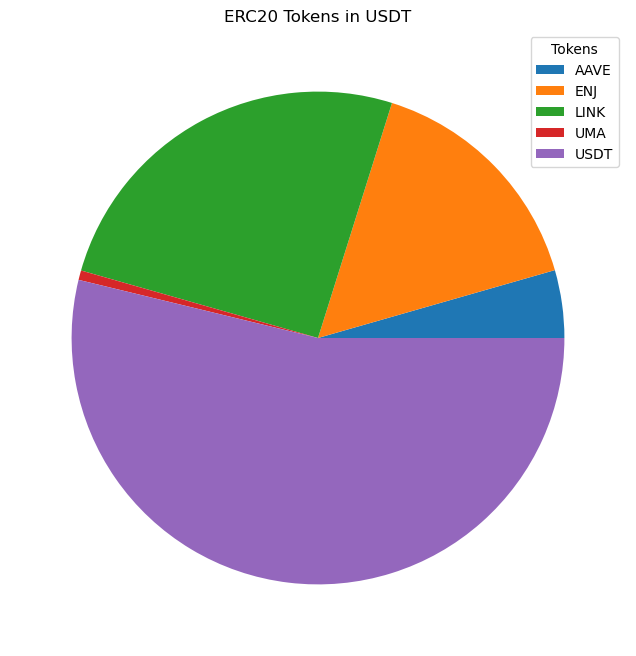

The following ERC20 Tokens are being held by the client: {('AAVE', 'Aave Token'): 1.55085293, ('ENJ', 'EnjinCoin'): 1524.12, ('LINK', 'ChainLink Token'): 81.84921653, ('UMA', 'UMA Voting Token v1'): 9.931, ('UNI-V2', 'Uniswap V2'): 0.0004610169957639411, ('USDT', 'Tether USD'): 1197.1001529999992}
For following ERC20 Tokens there was no price data: {('UNI-V2', 'Uniswap V2'): 0.0004610169957639411}


In [108]:
# Function calls

#ass_wallets = AssociatedWallets(CURRENCY)

#direction = 'out'

#addr_neigh = ass_wallets.bfs_neighbors(ADDRESS, 4, 10, True, direction)

#with open("results/addresses_" + direction + ".txt", "w") as outfile:
    #outfile.write(str(addr_neigh))

#blacklist = Blacklist()
#blacklist.ofac()
#print(blacklist.check_membership('ETH', ADDRESS, json_data))
#blacklist.check_dark_web('bc1q678w53nhk4da3rt2x8thfuytwvsenq0cwszzqw', 'data/wasabi_txs.parquet')
#blacklist.check_phishing_hack('0xd5E846494DF899e0D2eA5e628501Dfe420D2643b', 'data/hack_addresses_etherscan.json')


#ex = Exchange('eth')
#exchanges_used = ex.get_ex_used('0x49bd56B275395130B41D67E1304b2d49F8A88725', 'cex', 'out', 3)
#exchanges_used = ex.get_ex_tags('0x1d42064Fc4Beb5F8aAF85F4617AE8b3b5B8Bd801', 'dex')
#pprint(exchanges_used)

#pof = PoF('eth')
#print(pof.coinbase_data('candles', 'ETH-USD', '2023-01-01'))
#print(pof.binance_data('price', 'AUTOUSDT'))
#print(pof.coinbase_data('candles', 'ETH-USD', '2023-01-01'))
#pprint(pof.binance_table('ETHUSDT', '1h'))
#pof.check_profitloss('binance', 'ETHUSDT', '2018-08-09', '2023-09-10', 1, 1, -300)
#print(pof.get_address_txs(ADDRESS, 'in', 1))
#pof.get_wallet_overview('0x49bd56B275395130B41D67E1304b2d49F8A88725')
#pof.activity_analysis(ADDRESS, 5)

#nft = NFT()
#nfts_dict = nft.get_held_nfts(ADDRESS)
#print(nfts_dict)
#for nft in nfts_dict:
    #print(nft)

#erc20 = ERC20('eth')
#erc20_dict = erc20.get_erc20_transfers(ADDRESS)
#print(erc20_dict)
#print(erc20.get_erc20(ADDRESS))
#erc20.visualize('0x74c6199A17E39c9Cfa4583E14D132C0dDE5279b5')

#sc = SC()
#sc.get_sc_data('0x25ed58c027921e14d86380ea2646e3a1b5c55a8b', 'nft')

#mix_bridge = MixBridge()
#print(mix_bridge.check('0xA43Ce8Cc89Eff3AA5593c742fC56A30Ef2427CB0'.lower(), 'data/defi_fraud.yaml', 1))